Effect of sequencing depth on GenomeDISCO scores
===

In [1]:
import sys
import copy
import random
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import scipy as scipy
import math
from time import gmtime, strftime
import cProfile
import timeit
import scipy.sparse as sps
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)
import numpy as np
import gzip
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from time import gmtime, strftime
import gzip
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import matplotlib
import matplotlib.patches as patches
import math
from scipy.stats.mstats import mquantiles
from random import randint
from sklearn.metrics.cluster import adjusted_rand_score
from scipy import stats
from matplotlib import cm
import pandas as pd
import pandas
import math
import scipy
import collections
import sys
import gzip
import numpy as np
import os
import re
import gzip
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from time import gmtime, strftime
import matplotlib.pyplot as plt
import scipy.sparse as sps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib import rc
from matplotlib import rcParams
from numpy import linalg as LA
%matplotlib inline

Effect of sequencing depth on GenomeDISCO scores
===

Specifically, how do scores behave if samples are subsampled to the same depth vs not?

In [2]:
mnames=['GM12878_combined','HMEC','HUVEC','IMR90','K562','KBM7','NHEK']
subsamples=[10000,10001,100000,100001]

In [3]:

def read_nodes_from_bed(bedfile,blacklistfile='NA'):
    
    blacklist={}
    if blacklistfile!='NA':
        for line in gzip.open(blacklistfile):
            items=line.strip().split('\t')
            chromo,start,end=items[0],int(items[1]),int(items[2])
            if chromo not in blacklist:
                blacklist[chromo]=[]
            blacklist[chromo].append((start,end))
    
    #print "GenomeDISCO | "+strftime("%c")+" | processing: Loading genomic regions from "+bedfile

    nodes={}
    nodes_idx={}
    node_c=0
    blacklisted_nodes=[]
    for line in gzip.open(bedfile,'r'):
        items=line.strip().split('\t')
        chromo=items[0]
        start=int(items[1])
        end=int(items[2])
                
        node=items[3]
        if len(items)>4:
            include=items[4]
        
        if node in nodes.keys():
            #print "GenomeDISCO | "+strftime("%c")+" | Error: Genomic region appears multiple times in your file. One such example is "+node+". Please make sure all genomic regions are unique and re-run"
            sys.exit()
        if node not in nodes.keys():
            nodes[node]={}
            nodes[node]['idx']=node_c
            nodes[node]['chr']=chromo
            nodes[node]['start']=start
            nodes[node]['end']=end
            if len(items)>4:
                nodes[node]['include']=include
            nodes_idx[node_c]=node 
            
            if chromo in blacklist:
                for blacklist_item in blacklist[chromo]:
                    if (start<=blacklist_item[0] and end>=blacklist_item[0]) or (start<=blacklist_item[1] and end>=blacklist_item[1]) or (start>=blacklist_item[0] and end<=blacklist_item[1]):
                        blacklisted_nodes.append(node_c)
                
            node_c+=1
            
    return nodes,nodes_idx,blacklisted_nodes

def filter_nodes(m,to_remove):
    
    if len(to_remove)==0:
        return m
    
    nonzeros=m.nonzero()
    num_elts=len(nonzeros[0])
    
    r_idx=[i for i, x in enumerate(nonzeros[0]) if x not in to_remove]
    c_idx=[i for i, x in enumerate(nonzeros[1]) if x not in to_remove]
    keep=list(set(r_idx).union(set(c_idx)))
    
    coo_mat=m.tocoo()
        
    return csr_matrix((coo_mat.data[keep],(coo_mat.row[keep],coo_mat.col[keep])),shape=m.get_shape(),dtype=float) 
    

def construct_csr_matrix_from_data_and_nodes(f,nodes,blacklisted_nodes,remove_diag=True):
    #print "GenomeDISCO | "+strftime("%c")+" | processing: Loading interaction data from "+f

    total_nodes=len(nodes.keys())
    i=[]
    j=[]
    v=[]

    #print strftime("%c")
    c=0
    for line in gzip.open(f):
        items=line.strip().split('\t')
        n1,n2,val=nodes[items[0]]['idx'],nodes[items[1]]['idx'],float(items[2])
        mini=min(n1,n2)
        maxi=max(n1,n2)
        i.append(mini)
        j.append(maxi)
        v.append(val)
        c+=1

    csr_m=csr_matrix( (v,(i,j)), shape=(total_nodes,total_nodes),dtype=float)
    if remove_diag:
        csr_m.setdiag(0)
    return filter_nodes(csr_m,blacklisted_nodes)

def sqrtvc(m):
    mup=m
    mdown=mup.transpose()
    mdown.setdiag(0)
    mtogether=mup+mdown
    sums_sq=np.sqrt(mtogether.sum(axis=1)) 
    #make the ones that are 0, so that we don't divide by 0
    sums_sq[sums_sq==0.0]=1.0
    D_sq = sps.spdiags(1.0/sums_sq.flatten(), [0], mtogether.get_shape()[0], mtogether.get_shape()[1], format='csr')
    return sps.triu(D_sq.dot(mtogether.dot(D_sq)))

def subsample_to_depth(m,seq_depth):
    if type(m) is csr_matrix:
        return subsample_to_depth_csr_upperTri(m,seq_depth)
    if type(m) is np.ndarray:
        return subsample_to_depth_array_upperTri(m,seq_depth)

def subsample_to_depth_array_upperTri(m,seq_depth):
    m=np.triu(m)
    subsampled_data=np.zeros(m.shape)
    depthm=m.sum()
    assert seq_depth<=depthm
    subsampling_prob=seq_depth/depthm
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if j<=i:
                continue
            n=m[i,j]
            subsampled_data[i,j]=np.random.binomial(n,subsampling_prob,1)[0]
    return subsampled_data

def subsample_to_depth_csr_upperTri(m,seq_depth):
    depthm=m.sum()
    assert seq_depth<=depthm
    subsampling_prob=seq_depth/depthm

    m.eliminate_zeros()
    vals=m.data
    num_elts=len(vals)
    m_subsampled_data=[]#np.random.binomial(value,subsampling_prob)
    elt=0
    while elt<num_elts:
        m_subsampled_data.append(np.random.binomial(vals[elt],subsampling_prob,1)[0])
        elt+=1
    return csr_matrix((m_subsampled_data, m.indices, m.indptr), dtype=float,shape=m.shape)

node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
nodes,nodes_idx,blacklist_nodes=read_nodes_from_bed(node_file,'NA')
msubs={}
for mname in mnames:
    print mname
    msubs[mname]={}
    m1file='/ifs/scratch/oursu/data/chr21_datasets/'+mname+'.chr21.RAWobserved.gz'
    m1=construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)
    for s in subsamples:
        #print s
        msubs[mname][s]=subsample_to_depth(m1,s)
        #print msubs[mname][s].sum()

GM12878_combined
HMEC
HUVEC
IMR90
K562
KBM7
NHEK


In [4]:
def genomedisco_scoring(m1_csr,m2_csr,tmin,tmax,args_transition):
    m1up=m1_csr
    m1down=m1up.transpose()
    m1down.setdiag(0)
    m1=m1up+m1down

    m2up=m2_csr
    m2down=m2up.transpose()
    m2down.setdiag(0)
    m2=m2up+m2down
    
    #convert to an actual transition matrix
    if args_transition:
        m1=to_transition(m1)
        m2=to_transition(m2)
        
    #x=0.01
    #plt.matshow((m1-m2).toarray(),vmin=-x,vmax=x,cmap='bwr')
    #plt.show()

    #count nonzero nodes (note that we take the average number of nonzero nodes in the 2 datasets)
    rowsums_1=m1.sum(axis=1)                                                                          
    nonzero_1=[i for i in range(rowsums_1.shape[0]) if rowsums_1[i]>0.0]
    rowsums_2=m2.sum(axis=1)                                                                           
    nonzero_2=[i for i in range(rowsums_2.shape[0]) if rowsums_2[i]>0.0]
    nonzero_total=len(list(set(nonzero_1).union(set(nonzero_2))))
    nonzero_total=0.5*(1.0*len(list(set(nonzero_1)))+1.0*len(list(set(nonzero_2))))
    
    scores=[]
    for t in range(1,tmax+1): #range(args.tmin,args.tmax+1):   
        extra_text=' (not included in score calculation)'
        if t==1:
            rw1=copy.deepcopy(m1)
            rw2=copy.deepcopy(m2)
        else:
            rw1=rw1.dot(m1)
            rw2=rw2.dot(m2)
            if t>=tmin:
                diff=abs(rw1-rw2).sum()#+euclidean(rw1.toarray().flatten(),rw2.toarray().flatten()))
                scores.append(1.0-1.0*float(diff)/float(nonzero_total))
    return scores
                    

def genomedisco(m1,m2,args_m_subsample,args_norm,tmin,tmax,transition):
    #subsampling
    m1_subsample=copy.deepcopy(m1)
    m2_subsample=copy.deepcopy(m2)
    if args_m_subsample!='NA':
        if args_m_subsample=='lowest':
            if m1.sum()>=m2.sum():
                m_subsample=copy.deepcopy(m2)
            if m2.sum()>m1.sum():
                m_subsample=copy.deepcopy(m1)
        desired_depth=m_subsample.sum()
        if m1.sum()>desired_depth:
            m1_subsample=subsample_to_depth(m1,desired_depth)
        if m2.sum()>desired_depth:
            m2_subsample=subsample_to_depth(m2,desired_depth)
            
    #normalization
    m1_norm=process_matrix(m1_subsample,args_norm)
    m2_norm=process_matrix(m2_subsample,args_norm)
    
    #scoring
    scores=genomedisco_scoring(m1_norm,m2_norm,tmin,tmax,transition)
    return np.mean(np.array(scores))

def get_scoremat(dataset,samplenames):
    score_dict={}
    scoremat=np.zeros((len(samplenames),len(samplenames)))
    for s1 in range(len(samplenames)):
        print s1
        samplename1=samplenames[s1]
        if samplename1 not in score_dict.keys():
            score_dict[samplename1]={}
        for s2 in range(s1,len(samplenames)):
            if s1==s2:
                scoremat[s1,s2]=1.0
            #print 's2 '+str(s2)
            samplename2=samplenames[s2]
            if samplename2 not in score_dict.keys():
                score_dict[samplename2]={}
            cur_score=genomedisco(dataset[samplename1],dataset[samplename2],'NA','uniform',3,3,True)
            scoremat[s1,s2]=cur_score
            scoremat[s2,s1]=cur_score
            score_dict[samplename1][samplename2]=cur_score
            score_dict[samplename2][samplename1]=cur_score
    return scoremat,score_dict


def process_matrix(m,matrix_processing):
    if matrix_processing=='uniform':
        return uniform_processing(m)
    if matrix_processing=='coverage_norm':
        return coverage_norm(m)
    if matrix_processing=='sqrtvc':
        return sqrtvc(m)
    if matrix_processing=='fill_diagonal':
        return hichip_add_diagonal(m)
    
def uniform_processing(m):
    return m

def to_transition(mtogether):
    sums=mtogether.sum(axis=1)
    #make the ones that are 0, so that we don't divide by 0                                                   
    sums[sums==0.0]=1.0
    D = sps.spdiags(1.0/sums.flatten(), [0], mtogether.get_shape()[0], mtogether.get_shape()[1], format='csr')
    return D.dot(mtogether)

#================================

total_mats={}
total_mats_keys=[]
#mnames=['GM12878_combined','K562']
for mname in mnames:
    for s in subsamples:
        if s%10==0:
            total_mats[mname+'.'+str(s)+'.rep1']=msubs[mname][s]
            total_mats_keys.append(mname+'.'+str(s)+'.rep1')
        else:
            total_mats[mname+'.'+str(s-1)+'.rep2']=msubs[mname][s]
            total_mats_keys.append(mname+'.'+str(s-1)+'.rep2')
        
print total_mats_keys

scoremats={}
score_dicts={}
scoremats['seqdepth'],score_dicts['seqdepth']=get_scoremat(total_mats,total_mats_keys)

['GM12878_combined.10000.rep1', 'GM12878_combined.10000.rep2', 'GM12878_combined.100000.rep1', 'GM12878_combined.100000.rep2', 'HMEC.10000.rep1', 'HMEC.10000.rep2', 'HMEC.100000.rep1', 'HMEC.100000.rep2', 'HUVEC.10000.rep1', 'HUVEC.10000.rep2', 'HUVEC.100000.rep1', 'HUVEC.100000.rep2', 'IMR90.10000.rep1', 'IMR90.10000.rep2', 'IMR90.100000.rep1', 'IMR90.100000.rep2', 'K562.10000.rep1', 'K562.10000.rep2', 'K562.100000.rep1', 'K562.100000.rep2', 'KBM7.10000.rep1', 'KBM7.10000.rep2', 'KBM7.100000.rep1', 'KBM7.100000.rep2', 'NHEK.10000.rep1', 'NHEK.10000.rep2', 'NHEK.100000.rep1', 'NHEK.100000.rep2']
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


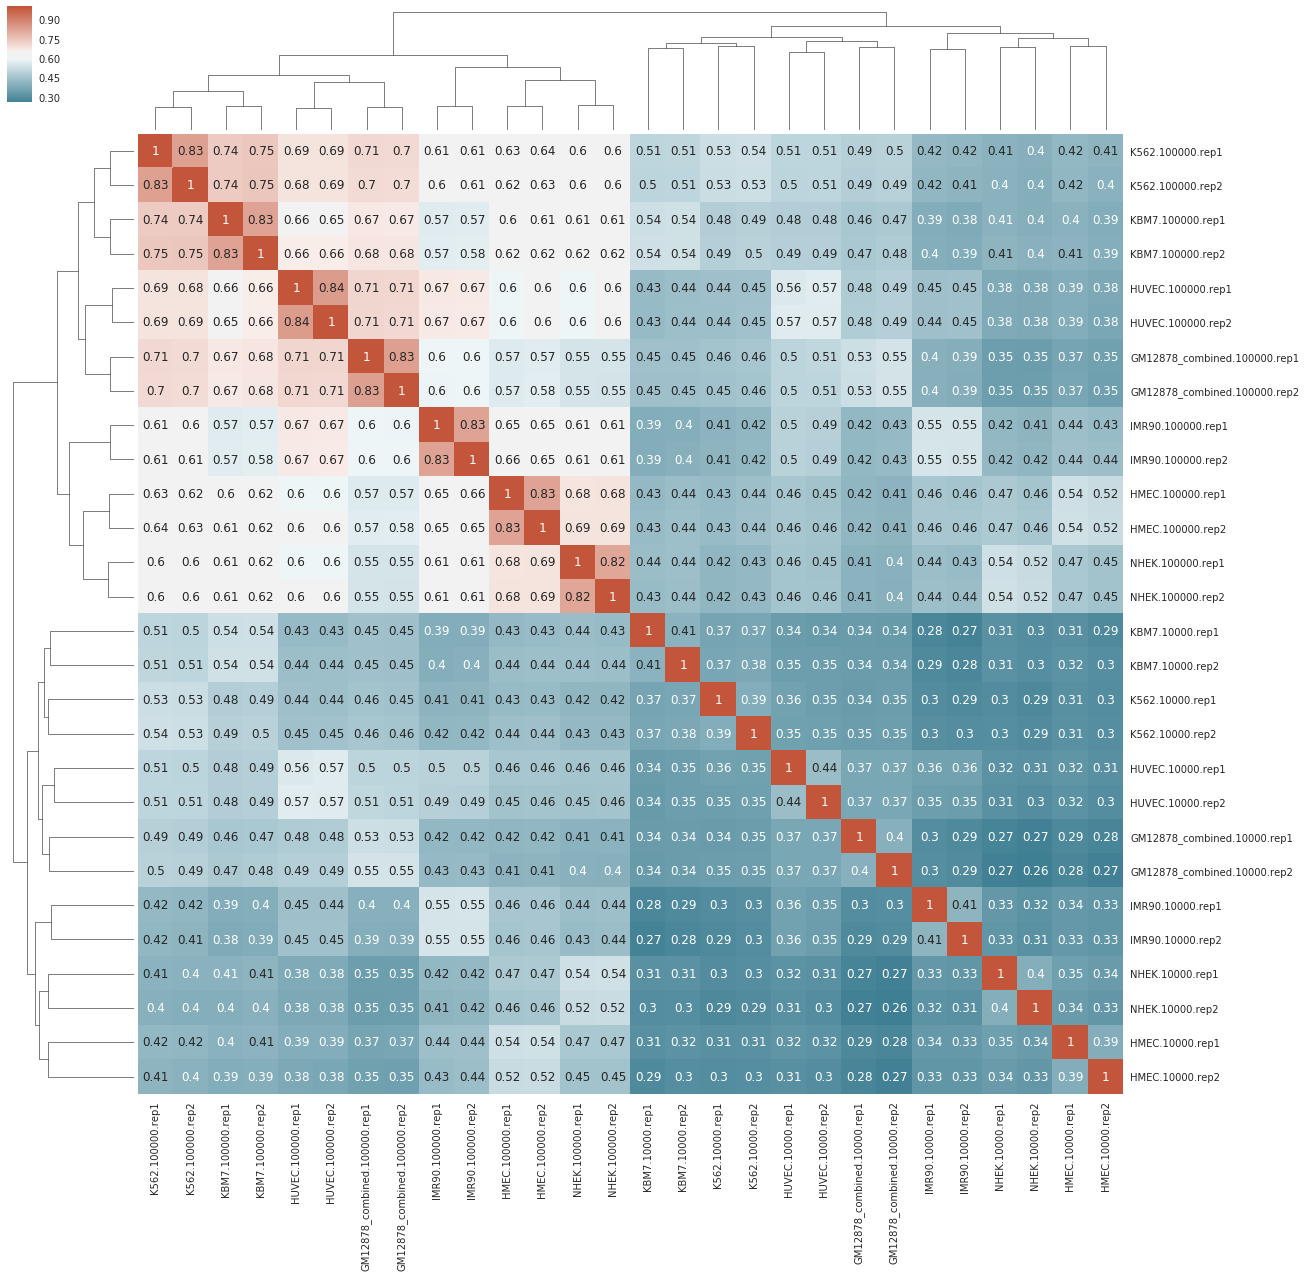

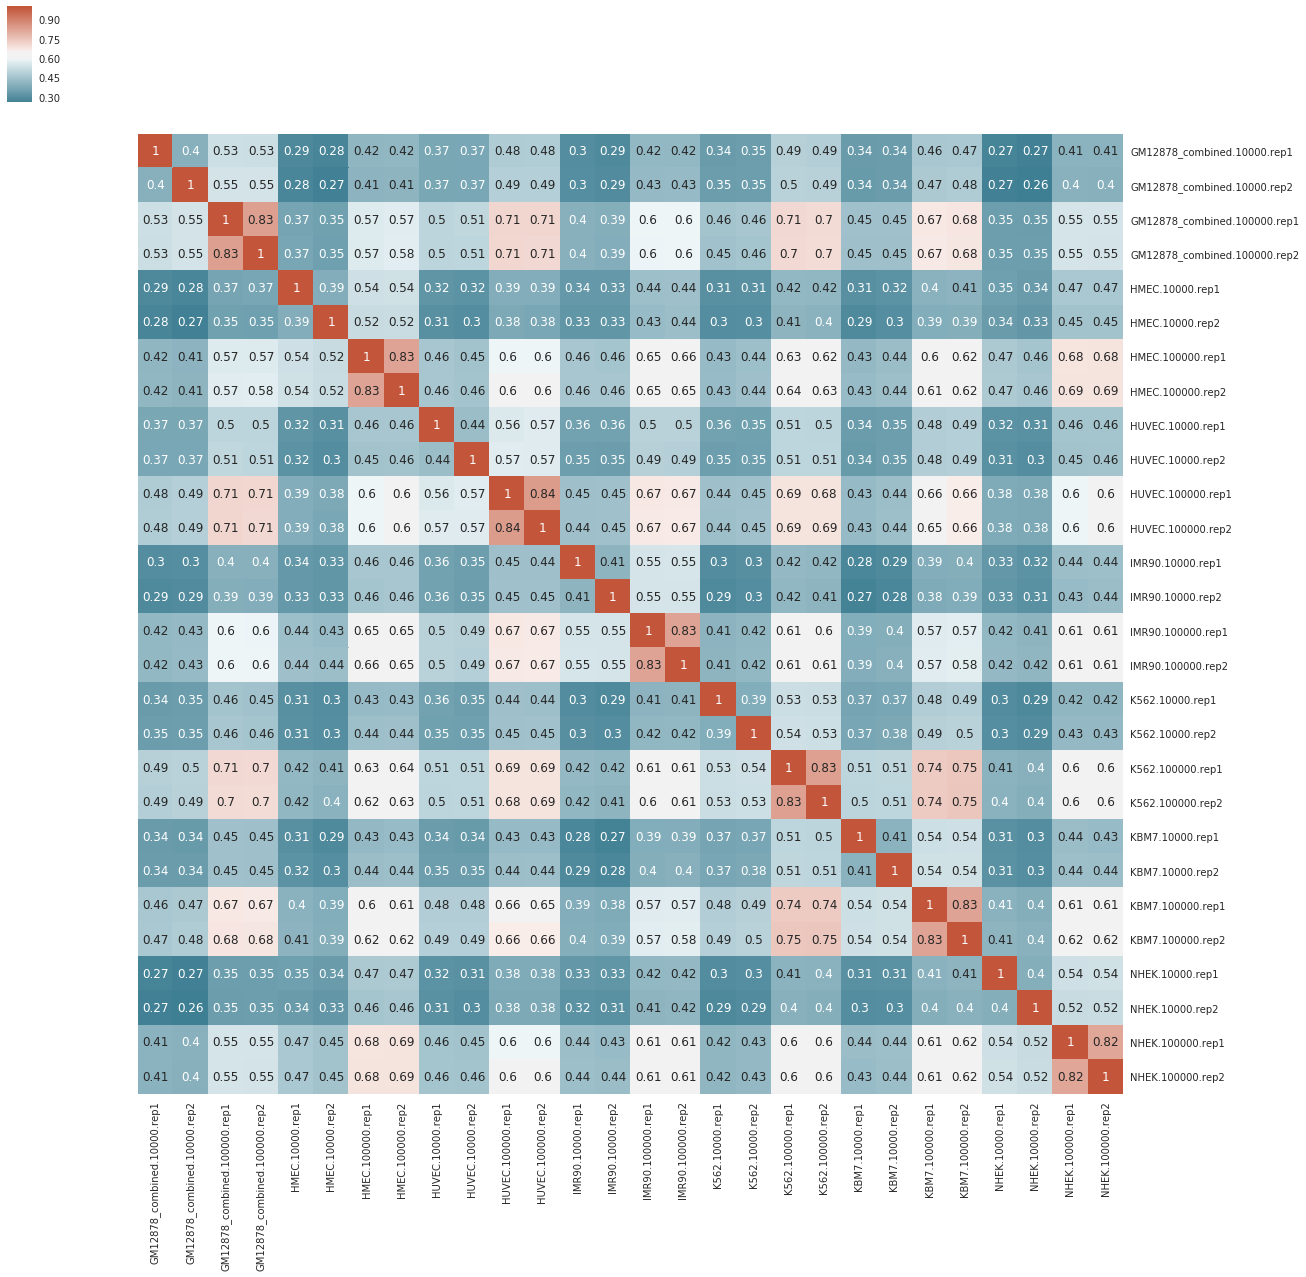

In [5]:
df=pandas.DataFrame(scoremats['seqdepth'], index=total_mats_keys, columns=total_mats_keys)
sns.set(font_scale=1.0)
sns_plot = sns.clustermap(df, annot=True,cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),figsize=(20,20))
sns_plot.savefig("/ifs/scratch/oursu/paper_2017-12-20/simulations/subsamplingAnalysis.clustered.png")

sns_plot = sns.clustermap(df, annot=True,cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),figsize=(20,20),row_cluster=False,col_cluster=False)
sns_plot.savefig("/ifs/scratch/oursu/paper_2017-12-20/simulations/subsamplingAnalysis.unclustered.png")